In [3]:
from datasets import Dataset
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from transformers import AutoModelForTokenClassification,AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification


In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/depolymerase_building/Phagedepo.Dataset.21032024.tsv \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb



In [4]:
import pandas as pd
import os 
from Bio import SeqIO
from collections import Counter
import subprocess

path_work = "/media/concha-eloko/Linux/depolymerase_building"
path_tmp = f"{path_work}/tmp"
os.makedirs(path_tmp, exist_ok=True)

df_depo = pd.read_csv(f"{path_work}/Phagedepo.Dataset.21032024.tsv" , sep = "\t" , header = 0)
df_depo = df_depo[df_depo["Fold"].isin(["Negative", "right-handed beta-helix", "6-bladed beta-propeller", "triple-helix"])]
df_depo = df_depo.drop_duplicates(subset = ["Full_seq"], keep = "first")
df_depo.reset_index(inplace = True)






> Make the cd hit input/outputs : 

In [5]:
dico_seq_id = {}
with open(f"{path_tmp}/training_sequences.fasta", "w") as outfile :
    for index, seq in enumerate(df_depo["Full_seq"].tolist()) : 
        outfile.write(f">{index}\n{seq}\n")
        if seq not in dico_seq_id : 
            dico_seq_id[seq] = index

for c_value in thresholds :
    make_cdhit_cluster(c_value)

NameError: name 'thresholds' is not defined

In [6]:
thresholds = [0.65, 0.7, 0.75, 0.8, 0.85]

def make_cdhit_cluster(threshold) :
    cdhit_command = f"cd-hit -i {path_tmp}/training_sequences.fasta -o {path_tmp}/{threshold}.out -c {threshold} -G 0 -aL 0.8"
    cdhit_process = subprocess.Popen(cdhit_command, shell =True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT) 
    scan_out, scan_err = cdhit_process.communicate()
    print(scan_out, scan_err)


def make_cluster_dico(cdhit_out) :
    import json
    dico_cluster = {}
    threshold = cdhit_out.split("/")[-1].split(".out")[0]
    cluster_file = f"{cdhit_out}.clstr"
    cluster_out = open(cluster_file).read().split(">Cluster")
    for index,cluster in enumerate(cluster_out[1:]) :
        tmp_dpo = []
        #id_cluster = f"Dpo_cdhit_{index}"
        id_cluster = index
        for _,line in enumerate(cluster.split("\n")[1:-1]) :
            dpo = line.split(">")[1].split(".")[0]
            tmp_dpo.append(dpo)
        dico_cluster[id_cluster] = tmp_dpo
    with open(f"{path_tmp}/dico_cluster.cdhit__{threshold}.json", "w") as outfile:
        json.dump(dico_cluster, outfile)
    return dico_cluster , threshold


def reverse_dico(dico) : 
    r_dico = {}
    for key,values in dico.items() :
        for _,id in enumerate(values) : 
            r_dico[id] = key
    return r_dico


def make_list_group(list_seq, r_dico, id_dico) :
    list_group = []
    for _,seq in enumerate(list_seq) :
        idd_seq = str(id_dico[seq])
        list_group.append(r_dico[idd_seq])
    return list_group


def cvalue_to_list_group(threshold, df_depo) :
    dico_cluster, _ = make_cluster_dico(f"{path_tmp}/{threshold}.out")
    r_dico_cluster = reverse_dico(dico_cluster)
    list_groups = make_list_group(df_depo["Full_seq"].tolist(), r_dico_cluster, dico_seq_id)
    return list_groups


def get_labels(tuple_data ) :
    dico_labels = {"Negative" : 0,
                   "right-handed beta-helix" : 1,
                   "6-bladed beta-propeller" : 2, 
                   "triple-helix" : 3}
    labels_df = []
    for _,row in enumerate(tuple_data) :
        info = row[1]
        seq_length = len(row[0])
        fold = row[2]
        label = dico_labels[fold]
        if info == "Negative" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info == "full_protein" or info == "full" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info.count(":") > 0 : 
            start = int(info.split(":")[0])
            end = int(info.split(":")[1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
        else :
            start = int(info.split("_")[-2])
            end = int(info.split("_")[-1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
    return labels_df


In [7]:
threshold = 0.8

list_test_1 = cvalue_to_list_group(threshold, df_depo)

In [8]:
gss_token_class = GroupShuffleSplit(n_splits=1, train_size=0.7, test_size = 0.3, random_state=243)
gss_seq_class = GroupShuffleSplit(n_splits=1, train_size=0.66, test_size = 0.34, random_state=243)

# First split :
train_token_classification_indices = []
Other_indices = []
for i, (train_index, test_index) in enumerate(gss_token_class.split(df_depo["Full_seq"], df_depo["Fold"], list_test_1)):
    train_token_classification_indices.append(train_index)
    Other_indices.append(test_index)

train_tok_seq = df_depo["Full_seq"][train_token_classification_indices[0]]
train_tok_boundaries = df_depo["Boundaries"][train_token_classification_indices[0]]
train_tok_fold = df_depo["Fold"][train_token_classification_indices[0]]

training_data_token_class = tuple(zip(train_tok_seq, train_tok_boundaries, train_tok_fold))
training_data_tok_labels = get_labels(training_data_token_class)



In [9]:
# Intermediate DF : 
df_depo_s2 = df_depo[df_depo.index.isin(Other_indices[0])]
df_depo_s2.reset_index(inplace = True)
df_depo_s2

,level_0,index,Seq_ID,Fold,Prob,Boundaries,Full_seq
0,1,1,MF417929_00041,Negative,manual,Negative,MNTPQPIQFDLMNPRQHGRILFAMGMSVSEIAKQIDEKRATVESWK...
1,2,2,MH616963_00015,Negative,manual,Negative,MAKDNYPFLDYINEDKSHYKTAASAGYKDDENLFLIGESGGFLMNI...
2,8,8,LR797314_00041,Negative,manual,Negative,MDHITEEMLAKFRDEHLYKHQRIIYDAGQDLLTCRNRIILKPRQVG...
3,10,10,AP013549_00033,Negative,manual,Negative,MAEYPTPVQMQILDYLENGPKRRVIAAFRGCGKSTLSAMYILWRLA...
4,13,13,AP013546_00036,Negative,manual,Negative,MNELWEPLPPALRDSFPNFACYLLRELRLADTPTRQQISVCDWMQN...
...,...,...,...,...,...,...,...
666,2201,2201,PL16__55,triple-helix,manual,137:347,MSKEVASARIQHRGMTTQGWESSPDILMEREIGIDMTTGYPKVGDG...
667,2208,2208,PL16__33,triple-helix,manual,0:210,MSLAGGIVTGQLRLKPNSGIEKSSSTGGAINIDMSKSKGAAMVMYT...
668,2214,2214,PL16__153,triple-helix,manual,142:343,MSKEVASARIQHRGMTKQEWESSSDILMEREIGIDMTTGYPKVGDG...
669,2216,2216,PL16__58,triple-helix,manual,103:301,MTETIPLRVQFKRMTAEEWARSDVILLESEIGFETDTGYAKFGDGK...


In [10]:
# Second split : 
list_test_2 = cvalue_to_list_group(threshold,df_depo_s2)
train_seq_classifiaction_indices = []
eval_data_indices = []

for i, (train_index, test_index) in enumerate(gss_seq_class.split(df_depo_s2["Full_seq"], df_depo_s2["Fold"], list_test_2)):
    train_seq_classifiaction_indices.append(train_index)
    eval_data_indices.append(test_index)

train_seq_seq = df_depo_s2["Full_seq"][train_seq_classifiaction_indices[0]]
train_seq_boundaries = df_depo_s2["Boundaries"][train_seq_classifiaction_indices[0]]
train_seq_fold = df_depo_s2["Fold"][train_seq_classifiaction_indices[0]]

# Sequence classification data :
training_data_seq_class = tuple(zip(train_seq_seq, train_seq_boundaries, train_seq_fold))
training_data_seq_labels = get_labels(training_data_seq_class)



In [11]:
# Ealuation data :
eval_seq = df_depo_s2["Full_seq"][eval_data_indices[0]]
eval_seq_boundaries = df_depo_s2["Boundaries"][eval_data_indices[0]]
eval_seq_fold = df_depo_s2["Fold"][eval_data_indices[0]]

eval_data_token_class = tuple(zip(eval_seq, eval_seq_boundaries, eval_seq_fold))
eval_data_token_labels = get_labels(eval_data_token_class)


In [12]:
Counter(train_tok_fold), Counter(train_seq_fold), Counter(eval_seq_fold)

(Counter({'Negative': 966,
          'right-handed beta-helix': 442,
          'triple-helix': 119,
          '6-bladed beta-propeller': 54}),
 Counter({'Negative': 286,
          'right-handed beta-helix': 105,
          '6-bladed beta-propeller': 34,
          'triple-helix': 17}),
 Counter({'Negative': 157,
          'right-handed beta-helix': 55,
          'triple-helix': 9,
          '6-bladed beta-propeller': 8}))

In [327]:
len(train_tok_fold), len(train_seq_fold), len(eval_seq_fold)

(1581, 442, 229)

In [ ]:

eval_data_token_class = tuple(zip(eval_seq, eval_seq_boundaries, eval_seq_fold))

***
> Prepare the labels 

***
# II. Fine-tuning ESM2

In [13]:
# First split :
train_tok_seq = df_depo["Full_seq"][train_token_classification_indices[0]]
train_tok_boundaries = df_depo["Boundaries"][train_token_classification_indices[0]]
train_tok_fold = df_depo["Fold"][train_token_classification_indices[0]]

training_data_token_class = tuple(zip(train_tok_seq, train_tok_boundaries, train_tok_fold))
training_data_tok_labels = get_labels(training_data_token_class)

# Ealuation data :
eval_seq = df_depo_s2["Full_seq"][eval_data_indices[0]]
eval_seq_boundaries = df_depo_s2["Boundaries"][eval_data_indices[0]]
eval_seq_fold = df_depo_s2["Fold"][eval_data_indices[0]]

eval_data_token_class = tuple(zip(eval_seq, eval_seq_boundaries, eval_seq_fold))
eval_data_token_labels = get_labels(eval_data_token_class)

In [18]:
# Define the model :
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
#model_checkpoint = "facebook/esm2_t12_35M_UR50D"
#model_checkpoint = "facebook/esm2_t30_150M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_tokenized = tokenizer(list(train_tok_seq))
test_tokenized = tokenizer(list(eval_seq))

train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", training_data_tok_labels)
test_dataset = test_dataset.add_column("labels", eval_data_token_labels)


Token indices sequence length is longer than the specified maximum sequence length for this model (1124 > 1024). Running this sequence through the model will result in indexing errors


In [11]:

num_labels = 4
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
data_collator = DataCollatorForTokenClassification(tokenizer)



Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.weight', 'cla

In [12]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [13]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 4

args = TrainingArguments(
    f"{model_name}-finetuned-depolymerase.0407.3_labels",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    push_to_hub=False,
)

In [14]:
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return metric.compute(predictions=predictions, references=labels)

In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

/home/concha-eloko/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 523
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 786


RuntimeError: CUDA out of memory. Tried to allocate 130.00 MiB (GPU 0; 1.96 GiB total capacity; 1.24 GiB already allocated; 66.38 MiB free; 1.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#!/bin/bash
#BATCH --job-name=FT_model
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=FT_model%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/fine_tune.esm2.py

***
# III. Testing the model :

In [ ]:
# import the model :
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase \
/media/concha-eloko/Linux/depolymerase_building/ 

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels \
/media/concha-eloko/Linux/depolymerase_building/ 

In [31]:
import pandas as pd
import os 
from collections import Counter
import torch
path_work = "/media/concha-eloko/Linux/depolymerase_building"
#path_work = "/home/conchae/PhageDepo_pdb"



In [29]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550/"
#model_path = "/home/conchae/PhageDepo_pdb/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase/checkpoint-198"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

model.eval()

Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0): EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementw

In [46]:
# Encode input text
input_text = "MTVKISGILKDALARPLANVAIRFLSLKTSSNIVIGVDTDFRTANDGSYDIDVVSGTYGVLMNFGSYEKIGEINVYNDSLPGTLEDFLTIPGIEEITPEILAQVIQARNNAVNAANNAASDATTIINEQLQNQKNEFDQFLLSSGYVFLGDYEDGPFQFSVRNQYIRYSNQYYRLDAATDVGFTTTGTDATSFASDVTHFVLMDGDTLRQNLGSSDGTSWVAKLGNKPLVAISYYKNQGLSDQDAVQAAFNESSNILIDHDIALTDYITFDRSEECYVYRKPGVTITGHGYLPKLRTNPAHVVETAIRHSKTSDRGGSYDRTYSHQSLAAEMVVHDVLSTDPGQENFVALYSGIESFNCQKQRMWAFNTVTSAHNLKTGDEIYGCEIDMNVDGTLDGGGQFVGVYIAGIGDVRTCANADGIRVQRLRDGVYKWQYGLRIFDSMTGINITDASTYSIFASGSAPIVRRKTTQDGGWSYTHSLSASSVKWGVDDYGDTYSRRLYLGTGDGKSKNRVNLDGGVSYYTTNAAVAWGSIAANAYVDKDITTLVGVSIADWTNYTIDVTPIGYAGAMPVVAVQAYINSTKTQAYVRIINISGAPLSSCNVGLNIKVSGHSATN"  # Replace this with your input text
input_ids = tokenizer.encode(input_text, return_tensors='pt', truncation= True)

# Get token classifications
with torch.no_grad() :
    outputs = model(input_ids)

# The model returns logits which can be turned into probabilities using softmax
import torch
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# the order of labels in model.config.id2label should match the order of probabilities in probs
labels = model.config.id2label

tokens = []
for token_id, token_probs in zip(input_ids[0], probs[0]):
    top_label_id = token_probs.argmax().item()
    tokens.append(int(labels[top_label_id].split("_")[1]))
    #print(f"{tokenizer.decode([token_id])}: {labels[top_label_id]}")
    
"""with open(f"{path_work}/output.token.txt", "w") as outfile :
    outfile.write(str(tokens))"""
dict(Counter(tokens))




{0: 370, 1: 249}

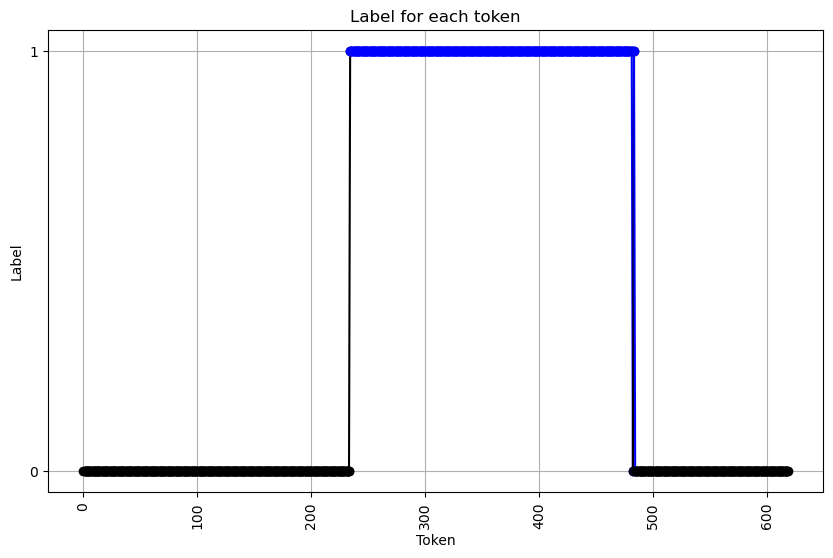

In [47]:
import matplotlib.pyplot as plt
import numpy as np

tokens = np.array(tokens)  # convert your list to numpy array for convenience

# create your plot
plt.figure(figsize=(10,6))

# plot data
for i in range(len(tokens) - 1):
    if tokens[i] == 0:
        color = 'black'
    elif tokens[i] == 1:
        color = 'blue'
    else:
        color = 'red'
        #tokens[i] == 1
    plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')

plt.xlabel('Token')
plt.ylabel('Label')
plt.title('Label for each token')
plt.xticks(rotation='vertical')
plt.yticks(np.arange(2), ['0', '1'])  
plt.grid(True)
plt.show()